#### Quake Heap Implementation

Given a set of items $P$ in which each item has a priority, the `quake-heap` on $P$ is defined as a `tournament forest` $\tau = \set{T_1, T_2, ...,T_L}$ where $T_i$ is a  (binary) tournament tree on $P_i \subset P$ such that $P_i \cap P_j = \empty$ if $i \neq j$.

The leaf-nodes in the forest are the items from $P$. All leaf nodes are maintained at the same height, which is the lowest level in the forest. We define $n_i$ as the number of nodes which have height $i$. We also maintain the following `invariant`: $n_{i+1} \leq \alpha n_i$ for $i=1,2,..,h_{max}-1$, where $\alpha \in (\frac{1}{2},1)$ is a fixed constant. 

The quake-heap data structure supports the following operations:

* `Link(T_1,T_2)` - creates a new node $u$ with $priority(u) = min(priority(root(T_1)), priority(root(T_2)))$, then attaches $T_1$ and $T_2$ as subtrees of u to form a new tree $T'$

* `cut(u)` -  given a node `u` whose priority is larger than that of it's parent $v$, this operation detaches u from it's parent to create a new tree rooted at $u$. 

* `Insert(u)` - inserts a new item $u$ into the quake-heap, this creates a new tree containing only $u$

* `Decrease-Min(x,k)` - first cut(u) is invoked, where u is the highest node containing the priority of item $x$, then the priority of item $x$ is changed to $k$. 

* `Delete-Min()`- deletes the item $x$ with smallest priority from the quake-heap, this is done in three steps:

    (i) remove all nodes in the $u$-$x$ path, where u is the highest node containing the priority of item $x$, we do this by performing a sequence of cut operation on every node in the path starting with the child of $u$ and after each cut, we delete the parent of the corresponding node on which we performed the cut. Finally when we reach the leaf and delete it's parent, we also delete the leaf.
    
    (ii) Link all pairs of trees which are at the same height

    (iii) Maintain number of nodes at height invariant property by finding the smallest height $h$ at which a violation occurs, i.e. the smallest $h$ for which $n_{h+1} > \alpha n_h$, and delete all nodes above this height. 

To facilitate the quake-heap operations, each node in the forest will have some auxiliary pointers:

* Each leaf node has a pointer to the highest internal node containing it's priority. 

* Each internal node has a pointer to the leaf node whose priority it contains.

To facilitate linking of trees in particular, we will also maintain a dictionary $A$ which maps height $i$ to a list of trees which have that height. We also maintain a list $L$ which contains all the heights for which at least two trees have that height, which allows us to quickly find all the heights at which we have pairs of trees that may be linked and retreive those trees. 

In [67]:
from collections import defaultdict
from graphviz import Digraph, Source

def add_nodes_edges(graph, node, counter=0):
    if node is not None:
        root = str(counter)
        graph.node(root, str(node.get_priority()), fontsize='10')
        if node.left is not None:
            left = str(counter + 1)
            graph.edge(root, left)
            counter = add_nodes_edges(graph, node.left, counter + 1)
        if node.right is not None:
            right = str(counter + 1)
            graph.edge(root, right)
            counter = add_nodes_edges(graph, node.right, counter + 1)
    return counter

def visualize_tree(root):
    graph = Digraph()
    add_nodes_edges(graph, root)
    return Source(graph.source)  


def visualize_forest(forest):
    for i, root in enumerate(forest):
        print(f'Tree {i+1}:')
        src = visualize_tree(root)
        display(src)

In [71]:
# linked list node
class LLNode:
    def __init__(self, data=None, prev=None, next=None):
        self.data = data
        self.prev = prev
        self.next = next

# doubly linked list data structure
class DoubleLinkedList():
    def __init__(self):
        self.head = None
        self.tail = None
        self.size = 0

    def delete(self, node):
        if node == self.head:
            self.head = node.next
        if node == self.tail:
            self.tail = node.prev
        if node.prev is not None:
            node.prev.next = node.next
        if node.next is not None:
            node.next.prev = node.prev
        self.size -= 1    

    def insert(self, node):
        if self.head is None:
            self.head = node
            self.tail = node
        else:
            node.next = self.head
            self.head.prev = node
            self.head = node
        self.size += 1

# tournament tree node
class TreeNode:
    def __init__(self, priority=None, data=None, left=None, right=None, parent=None, height=None, aux_leaf=None, aux_highest=None):
        self.priority = priority
        self.data = data
        self.left = left
        self.right = right
        self.parent = parent
        self.height = height
        self.aux_leaf = aux_leaf        # auxiliary pointer to leaf node 
        self.aux_highest = aux_highest  # auxiliary pointer to highest internal node

    def get_priority(self):
        return self.priority if self.aux_leaf is None else self.aux_leaf.priority    
    
    def get_min_leaf(self):
        return self if self.aux_leaf is None else self.aux_leaf


# quake heap data structure
class QuakeHeap():
    def __init__(self):
        self.size = 0 # number of item in forest      
        self.A = defaultdict(dict)   # dictionary mapping height to a dictionary containing: [list of trees of that height, pointer to that height in the doubly-linked list of heights with linkable trees if there are at least two trees of that height in the forest]
        self.L = DoubleLinkedList()    # doubly-linked list of heights for which at least two trees have that height (i.e. heights with linkable trees)
        self.items = [] # list of pointers to all items ever inserted into the forest

    def get_forest(self):
        # return the forest as a list of trees
        forest = []
        for i in self.A:
            forest.extend(self.A[i]['trees'])
        return forest

    def add_tree_to_dict(self, tree):
        if tree.height in self.A:
            self.A[tree.height]['trees'].append(tree)
            if len(self.A[tree.height]['trees']) == 2:
                # insert this height into the doubly-linked list of heights with linkable trees, only need to insert once when the number of trees becomes 2
                height_node = LLNode(data=tree.height)
                self.L.insert(height_node)  
                self.A[tree.height]['pointer'] = height_node
        else:
            self.A[tree.height] = {'trees':[tree], 'pointer':None}


    def insert(self, priority, data=None):
        """
        Insert a new node with given priority and data into the forest
        """
        new_node = TreeNode(priority=priority, data=data, height=1)
        self.add_tree_to_dict(new_node)
        self.size += 1
        self.items.append(new_node)       

    
    def decrease_key(self, x, new_priority):
        # make sure the new priority is less than the current priority
        assert new_priority < x.get_priority(), "New priority is not less than the current priority"
        # if the node is not the root of the tree, cut the highest internal node containing this priority
        if x.parent is not None:
            u = x.aux_highest
            self.cut(u)
        # update the priority of the node
        x.priority = new_priority    

    # cut operation at node u
    def cut(self, u):
        # make sure u has larger priority than it's parent
        print(f"Priotity of u: {u.get_priority()}, Priority of parent: {u.parent.get_priority()}")
        assert u.get_priority() > u.parent.get_priority(), "Priority of u is not greater than it's parent, cannot cut"
        # disconnect u from it's parent to get a new tree rooted at u
        v = u.parent
        if v.left == u:
            v.left = None
        else:
            v.right = None
        u.parent = None
        # add the new tree to dictionary
        self.add_tree_to_dict(u)


    # find and link all pairs of trees of the same height
    def find_and_link(self):
        # traverse list L from the beginning to the end
        current_height = self.L.head
        while current_height is not None:
            height = current_height.data
            # get the list of trees of this height
            trees = self.A[height]['trees']
            # link all pairs of trees of this height
            while len(trees) >= 2:
                T1 = trees.pop()
                T2 = trees.pop()
                print(f"Merging trees of height: {height}, T1: {T1.get_priority()}, T2: {T2.get_priority()}")
                # link T1 and T2 to get a new tree T
                T = self.link(T1, T2)
                self.size += 1
                # add new tree to height dictionary
                self.add_tree_to_dict(T)

            # remove the height from the doubly-linked list of heights with linkable trees
            self.L.delete(current_height)
            # move to the next avaliable height in the doubly-linked list
            current_height = self.L.head


    """
        T1 : root node of first tree
        T2 : root node of second tree 
    """
    def link(self, T1, T2):
        # create a new root node and attach T1 and T2 as it's subtrees
        new_root = TreeNode(height=T1.height+1)
        new_root.left = T1
        new_root.right = T2
        T1.parent = new_root
        T2.parent = new_root
        # find which subtree has the lower priority and get it's auxiliary pointer to it's leaf node
        aux_leaf = T1.get_min_leaf() if (T1.get_priority() < T2.get_priority()) else T2.get_min_leaf() 
        # create pointers to and from the new root node and the auxiliary leaf node
        new_root.aux_leaf = aux_leaf
        aux_leaf.aux_highest = new_root

        return new_root


Inserted item with priority 1
Inserted item with priority 2
Inserted item with priority 3
Inserted item with priority 4
Inserted item with priority 5
Tree 1:


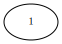

Tree 2:


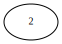

Tree 3:


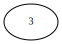

Tree 4:


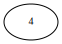

Tree 5:


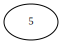

Merging trees of height: 1, T1: 5, T2: 4
Merging trees of height: 1, T1: 3, T2: 2
Merging trees of height: 2, T1: 2, T2: 4
Tree 1:


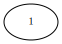

Tree 2:


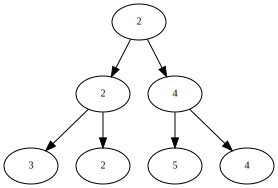

In [72]:
# test the QuakeHeap class
QH = QuakeHeap()
P = [1, 2, 3, 4, 5] # example item priorities
# isert all items into the heap
for item in P:
    QH.insert(item)
    print(f"Inserted item with priority {item}")

# visualize the forest 
visualize_forest(QH.get_forest())    

# find and link all pairs of trees of the same height   
QH.find_and_link()

# visualize the forest after linking
visualize_forest(QH.get_forest())

Priotity of u: 4, Priority of parent: 2
Tree 1:


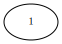

Tree 2:


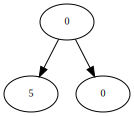

Tree 3:


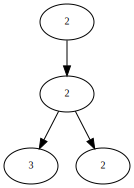

In [73]:
# decrease the priority of item 4 to 0
u = QH.items[3]
QH.decrease_key(u, 0)
visualize_forest(QH.get_forest())
